In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

import missingno as msno

pandas.set_option('display.max_columns', 500)
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import precision_recall_curve

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

from sklearn import metrics

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
data = pandas.read_csv('..//Data//Leads.csv')

## Functions

In [3]:
def imputation(data, column, value):
    data.loc[data[column].isnull()==True,column] = value
    return data

In [4]:
def ratio_plots_cat(data, var, target):
    plot_data = data.loc[data[var].isnull()==False]
    plot_data = plot_data.groupby(var).agg({target:['sum','count']})
    plot_data.columns = ['issue_count', 'total_count']
    plot_data['issue%'] = plot_data['issue_count'] / plot_data['total_count']
    plot_data = plot_data.reset_index()
    plot_data = plot_data.sort_values(by = 'issue%')
    plt.figure(figsize=(10,7))
    plt.bar(plot_data[var].astype('str'),plot_data['issue%'])
    plt.xticks(rotation=45)
    plt.xlabel(var)
    plt.ylabel("Converted %")
    plt.title(var)
    plt.show()
    
    
def ratio_plots_num(data, var, target, nBins):
    plot_data = data.loc[data[var].isnull()==False]
    
    m=min(data[var])
    M=max(data[var])

    bins=list(numpy.linspace(m,M,nBins+1,endpoint=True))
    
    plot_data[var+'_bins'] = pandas.cut(plot_data[var],bins=bins)
    plot_data = plot_data.groupby(var+'_bins').agg({target:['sum','count']})
    plot_data.columns = ['issue_count', 'total_count']
    plot_data['issue%'] = plot_data['issue_count'] / plot_data['total_count']
    plot_data = plot_data.reset_index()
    plt.figure(figsize=(7,7))
    plt.bar(plot_data[var+'_bins'].astype('str'),plot_data['issue%'])
    plt.xticks(rotation=45)
    plt.title(var)
    plt.xlabel(var)
    plt.ylabel("Converted %")
    plt.show()
    
    
def outlier_boxplot(data, var_list):
    for var in var_list:
        Q1 = data[var].quantile(0.25)
        Q3 = data[var].quantile(0.75)
        IQR = Q3 - Q1
        outlier_count=((data[var] < (Q1 - 1.5 * IQR)) | (data[var] > (Q3 + 1.5 * IQR))).sum()
        ax=plt.figure()
        ax.text(0.91,0.85,'outlier_count = '+str(outlier_count),fontsize=18,bbox=dict(facecolor='red', alpha=0.3))
        ax.text(0.91,0.75,'% outliers = '+str(round(outlier_count*100/data[var].shape[0],2)),
                fontsize=18,bbox=dict(facecolor='red', alpha=0.3))
        sns.boxplot(data[var],orient='v', showfliers=False)
        plt.text

In [5]:
def predict_summarize(X, y, model, threshold, plot_roc_=False):
    y_pred = model.predict(X)
    y_pred = y_pred.values.reshape(-1)
    y_pred_final = pandas.DataFrame({'Converted':y.values, 'Converted_Probability':y_pred})
    y_pred_final['CustID'] = y.index
    y_pred_final['predicted'] = y_pred_final['Converted_Probability'].map(lambda x: 1 if x > threshold else 0)

    # Confusion matrix 
    confusion = metrics.confusion_matrix(y_pred_final['Converted'], y_pred_final['predicted'] )
    
    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives
    
    sensitivity = TP / float(TP+FN)
    specificity = TN / float(TN+FP)
    false_positive_rate = FP/ float(TN+FP)
    precision = TP / float(TP + FP)
    recall = TP / float(TP + FN)
    
    confusion = pandas.DataFrame(confusion)
    confusion.columns = ['predicted_no','predicted_yes']
    confusion['ind'] = ['actual_no','actual_yes']
    confusion = confusion.set_index('ind')
    
    print('Accuracy = ',metrics.accuracy_score(y_pred_final['Converted'], y_pred_final.predicted))
    print('Sensitivity = ',sensitivity)
    print('Specificity = ',specificity)
    print('False Positive Rate = ',false_positive_rate)
    print('\nPrecision = ',precision)
    print('Recall = ',recall)
    
    if plot_roc_:
        plot_roc(y_pred_final['Converted'], y_pred_final['Converted_Probability'])
    
  
    return confusion

def plot_roc( actual, probs ):
    print('Plotting')
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

def plot_precision_recall_curve(X, y, model):
    y_pred = model.predict(X)
    y_pred = y_pred.values.reshape(-1)
    y_pred_final = pandas.DataFrame({'Converted':y.values, 'Converted_Probability':y_pred})
    y_pred_final['CustID'] = y.index
    
    p, r, thresholds = precision_recall_curve(y_pred_final['Converted'], y_pred_final['Converted_Probability'])
    plt.plot(thresholds, p[:-1], "g-",label='precision')
    plt.plot(thresholds, r[:-1], "r-",label='recall')
    plt.xlabel('Thresholds')
    plt.title('Precision Recall Curve')
    plt.legend()
    plt.show()
    
def ks_metric(X, y, model, threshold):
    y_pred = model.predict(X)
    y_pred = y_pred.values.reshape(-1)
    y_pred_final = pandas.DataFrame({'Converted':y.values, 'Converted_Probability':y_pred})
    y_pred_final['CustID'] = y.index
    y_pred_final['predicted'] = y_pred_final['Converted_Probability'].map(lambda x: 1 if x > threshold else 0)
    
    y_pred_final = y_pred_final.sort_values(by=['Converted_Probability'],ascending=False)
    y_pred_final['dummy'] = 1
    y_pred_final['rank'] = y_pred_final['dummy'].cumsum()
    y_pred_final['decile'] = pandas.cut(y_pred_final['rank'], 10, labels=False)
    
    ks_data = y_pred_final.groupby('decile').agg({
        'Converted':['sum','count'],
        'Converted_Probability':['min','max']
    }).reset_index()
    ks_data.columns = ['decile','converted_count','total_count','min_prob','max_prob']
    ks_data['event_rate'] = round((ks_data['converted_count']/ks_data['converted_count'].sum())*100,2)
    ks_data['non_event_rate'] = round(((ks_data['total_count'] - ks_data['converted_count'])/(ks_data['total_count'] - ks_data['converted_count']).sum()) * 100,2)

    ks_data['cum_event_rate'] = ks_data['event_rate'].cumsum()
    ks_data['cum_non_event_rate'] = ks_data['non_event_rate'].cumsum()

    ks_data['KS'] = round(ks_data['cum_event_rate'] - ks_data['cum_non_event_rate'], 2)

    start_ = ks_data.loc[ks_data['KS']==ks_data['KS'].max()]['cum_non_event_rate'].values[0]
    end_ = ks_data.loc[ks_data['KS']==ks_data['KS'].max()]['cum_event_rate'].values[0]
    index_ = ks_data.loc[ks_data['KS']==ks_data['KS'].max()]['decile'].values[0]

    plt.figure(figsize=(15,5))
    plt.plot(ks_data['decile'], ks_data['cum_event_rate'], label='Cumulative Event Rate')
    plt.plot(ks_data['decile'], ks_data['cum_non_event_rate'], label='Cumulative Non-Event Rate')
    plt.vlines(x=index_, ymax=end_, ymin=start_, colors="r", linestyles="--")
    plt.title('KS')
    plt.xlabel('Deciles')
    plt.ylabel('Cumulative Rate')
    plt.grid()
    plt.legend()
    print('KS of '+str((end_-start_))+' in decile = '+str(index_))
    return ks_data

def plot_feature_importance(model):
    feature_importance = pandas.DataFrame(model.params[1:])
    feature_importance['abs_value'] = abs(feature_importance[0])
    feature_importance = feature_importance.sort_values('abs_value',ascending=False)
    plt.figure(figsize=(10,10))
    sns.barplot(feature_importance[0],feature_importance.index,palette='husl')
    plt.title('Feature Importances')

In [6]:
def vif_ranks(data, features, row_count):
    vif = pandas.DataFrame()
    vif['Features'] = data[features].columns
    vif['VIF'] = [variance_inflation_factor(X_train[features].values, i) for i in range(X_train[features].shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif.head(row_count)

## EDA

In [7]:
data.columns

Index(['Prospect ID', 'Lead Number', 'Lead Origin', 'Lead Source',
       'Do Not Email', 'Do Not Call', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'Country', 'Specialization', 'How did you hear about X Education',
       'What is your current occupation',
       'What matters most to you in choosing a course', 'Search', 'Magazine',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses', 'Tags', 'Lead Quality',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'Lead Profile', 'City', 'Asymmetrique Activity Index',
       'Asymmetrique Profile Index', 'Asymmetrique Activity Score',
       'Asymmetrique Profile Score',
       'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

In [8]:
pandas.DataFrame(data.dtypes)

,0
Prospect ID,object
Lead Number,int64
Lead Origin,object
Lead Source,object
Do Not Email,object
Do Not Call,object
Converted,int64
TotalVisits,float64
Total Time Spent on Website,int64
Page Views Per Visit,float64


In [9]:
data.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


#### Observation:
All the columns have an appropriate data type and will not require any typecasting. Although, values like 'Select' would have to be treated as a missing value.

### Missing Value Check

In [10]:
data = data.replace({'Select':numpy.nan})

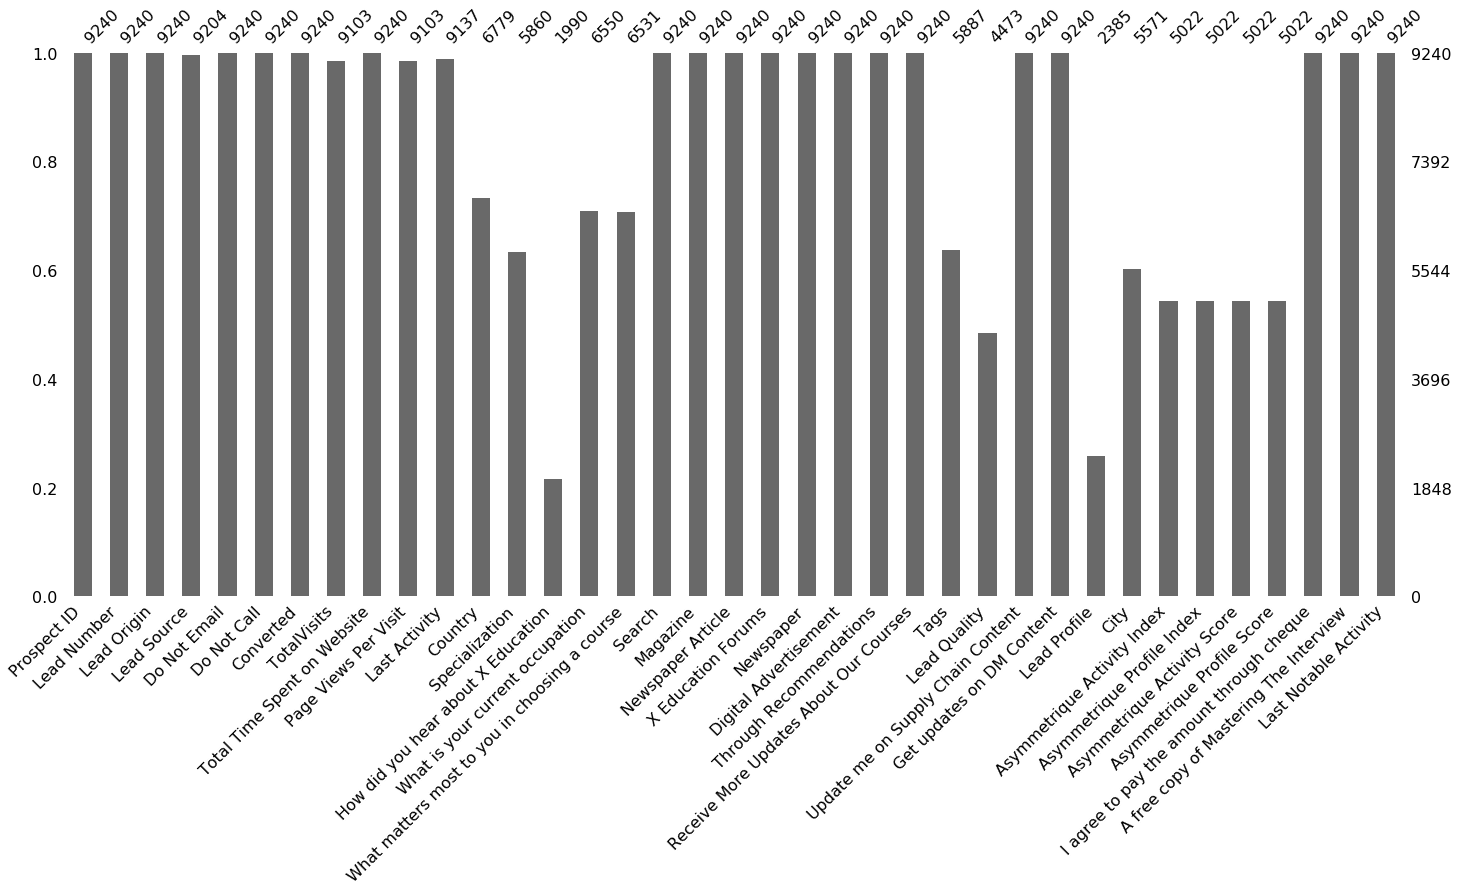

In [11]:
msno.bar(data)

In [12]:
missing_value_summary = pandas.DataFrame(data.isnull().sum()*100/data.shape[0])
missing_value_summary.columns = ['Invalid Data %']
missing_value_summary.loc[missing_value_summary['Invalid Data %']>0].sort_values('Invalid Data %')

,Invalid Data %
Lead Source,0.389610
Last Activity,1.114719
TotalVisits,1.482684
Page Views Per Visit,1.482684
Country,26.634199
What is your current occupation,29.112554
What matters most to you in choosing a course,29.318182
Tags,36.287879
Specialization,36.580087
City,39.707792


#### Observation:
A lot of the variables have 10% + missing values. We can remove few of these columns like 'How did you hear about X Education', 'Lead Profile'. When it comes to variables like 'Lead Quality', 'What matters most to you in choosing a course', we can retain the variables, and instead impute them with 'NA'.  

'Total Visits' & 'Page Views per Visit' can be imputed with 0 as a missing value in this case means that the lead has never visited the site.
All the 4 Asymmetrique scores/index can be imputed with 0 as it means that there are no scores assigned for these leads.

### Imputation

In [13]:
data = data.drop(['How did you hear about X Education','Lead Profile'], axis=1)

In [14]:
data = imputation(data, 'TotalVisits', 0)
data = imputation(data, 'Page Views Per Visit', 0)

data = imputation(data, 'Asymmetrique Activity Score', 0)
data = imputation(data, 'Asymmetrique Activity Index', 'NA')
data = imputation(data, 'Asymmetrique Profile Score', 0)
data = imputation(data, 'Asymmetrique Profile Index', 'NA')

data = imputation(data, 'Lead Source', 'NA')
data = imputation(data, 'Country', 'NA')
data = imputation(data, 'What is your current occupation', 'NA')
data = imputation(data, 'What matters most to you in choosing a course', 'NA')
data = imputation(data, 'Tags', 'NA')
data = imputation(data, 'Specialization', 'NA')
data = imputation(data, 'City', 'NA')
data = imputation(data, 'Lead Quality', 'NA')

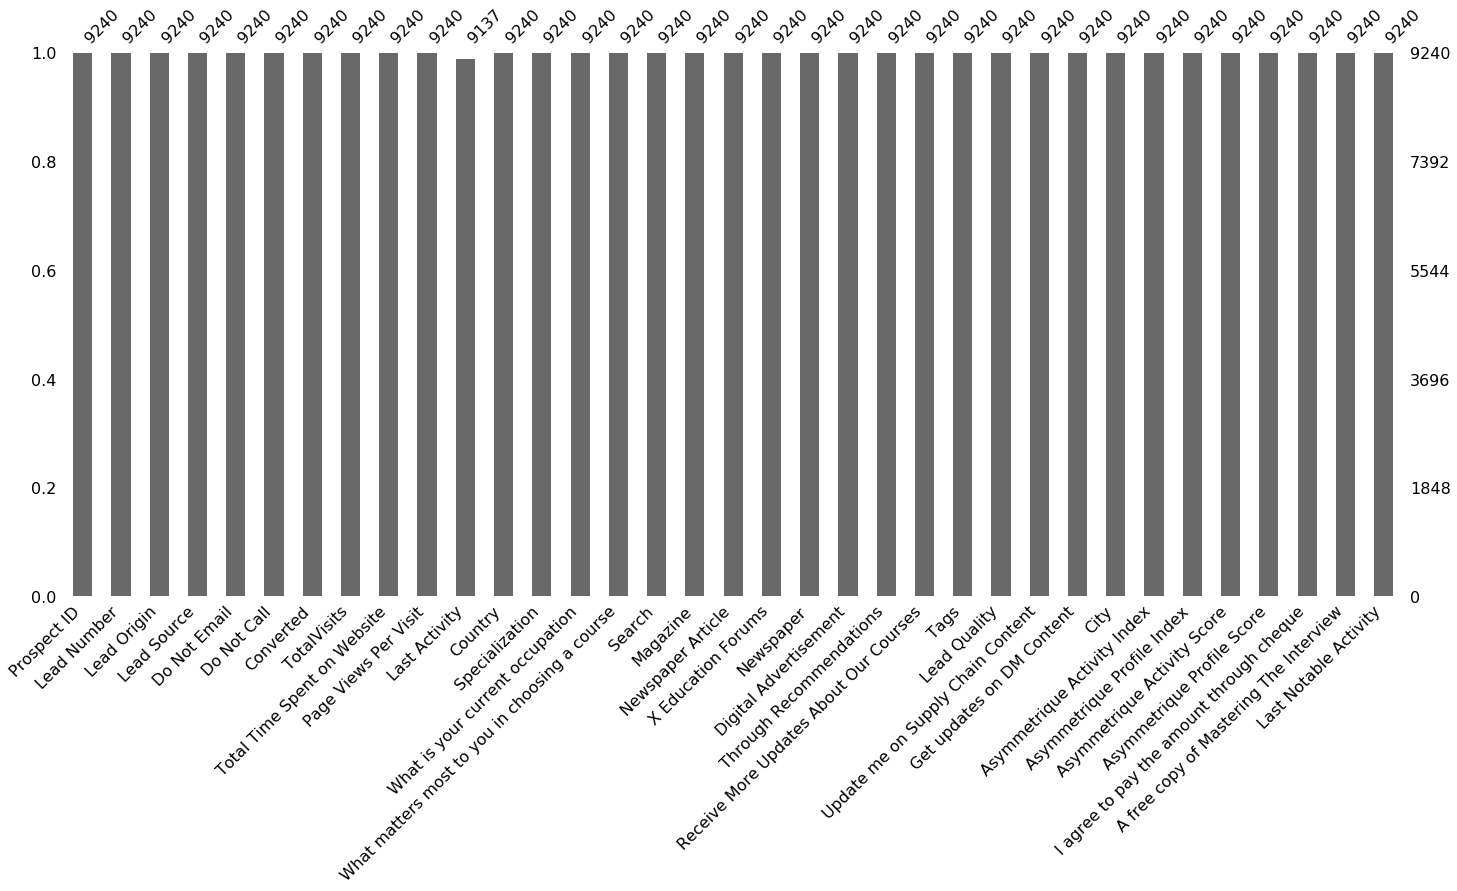

In [15]:
msno.bar(data)

#### Observation:
All the missing values have been addressed.

### Outliers Analysis

In [16]:
numerical_variables=['TotalVisits','Asymmetrique Activity Score','Asymmetrique Profile Score',
        'Total Time Spent on Website','Page Views Per Visit']

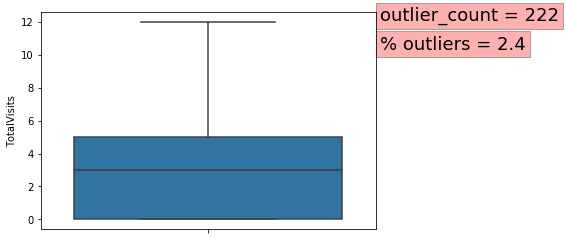

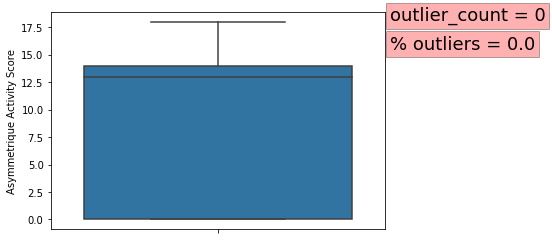

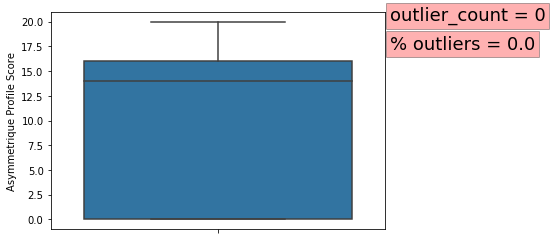

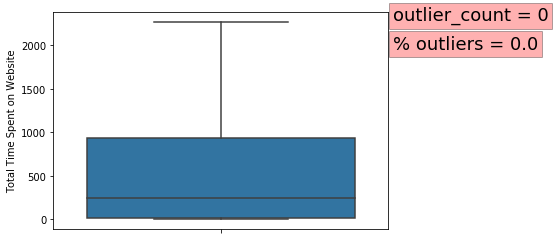

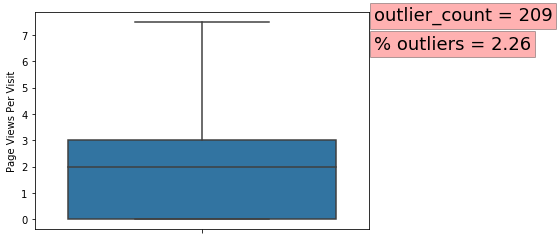

In [17]:
outlier_boxplot(data, numerical_variables)

#### Observation:
Only the 2 numerical variables 'Total Vists' & 'Page Views Per Visit' have few (~ 2%-3%) outlier values, which might be highly possible. There might be interested candidates who do a thorough research and hence instead of removing the rows with such cases, we can cap them upto a particular value.

In [18]:
data.loc[data['TotalVisits'] > 12,'TotalVisits'] = 15 
data.loc[data['Page Views Per Visit'] > 12,'Page Views Per Visit'] = 10

### Convertion Ratio

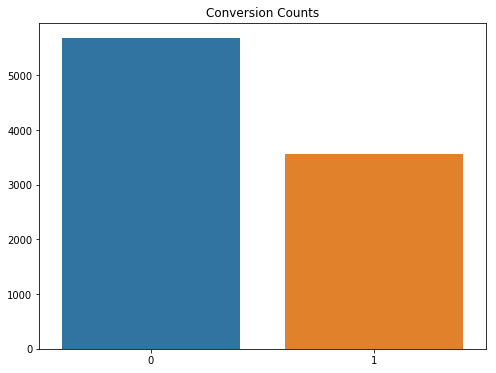

In [19]:
plt.figure(figsize=(8,6))
plt.title('Conversion Counts')
sns.barplot(x=data['Converted'].value_counts().index,y=[data['Converted'].value_counts()[0],data['Converted'].value_counts()[1]],orient='v')

#### Observation:
There clearly seems to be no issue of class imbalance in this scenario.

### Distribution & Spread of Conversion Ratio Across Categorical Variables

In [20]:
categorical_variables = ['Lead Origin', 'Lead Source',
       'Do Not Email', 'Do Not Call',
       'Country', 'Specialization', 'What is your current occupation',
       'What matters most to you in choosing a course', 'Search', 'Magazine',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses', 'Tags', 'Lead Quality',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'City', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index',
       'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity']

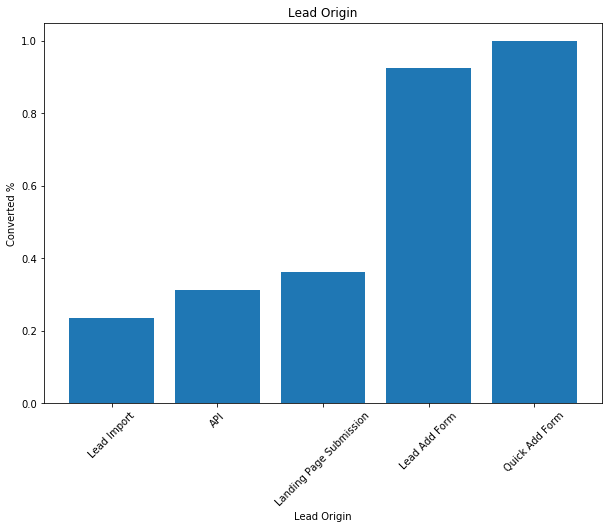

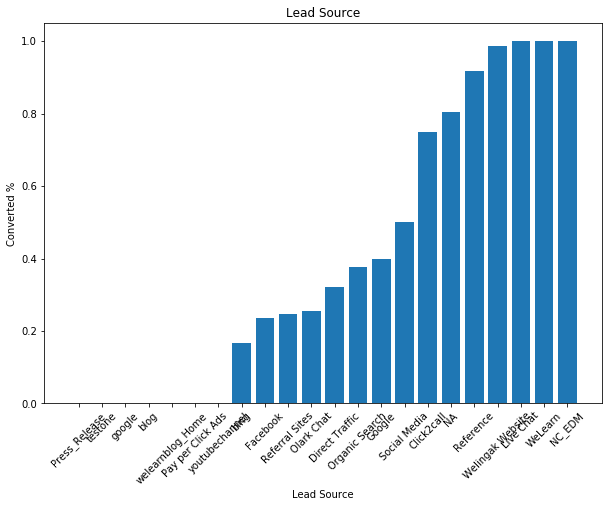

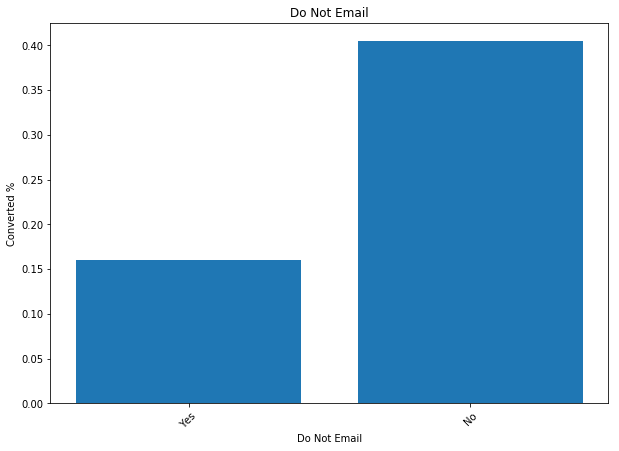

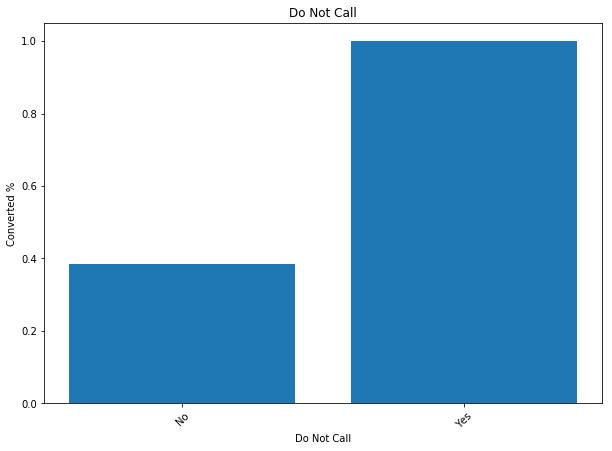

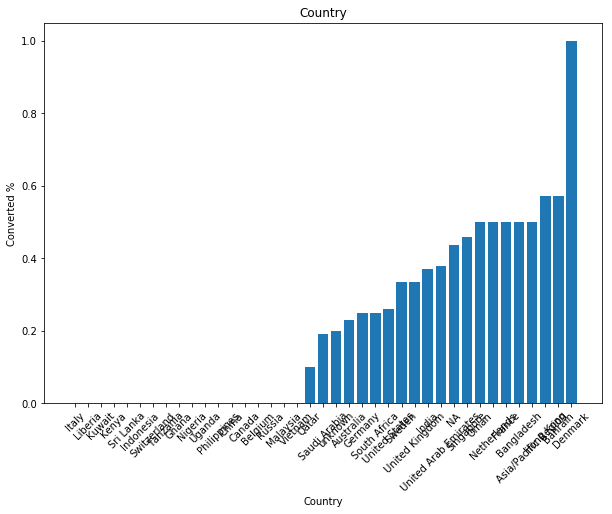

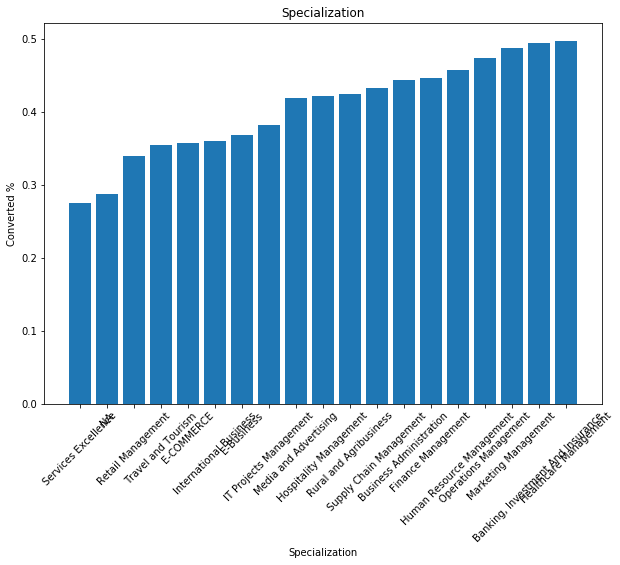

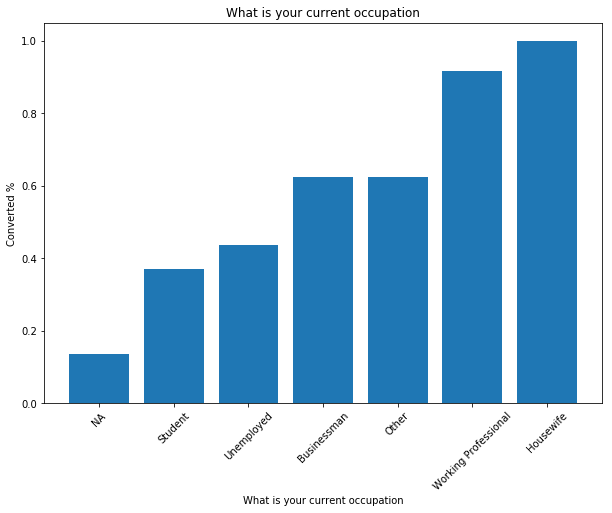

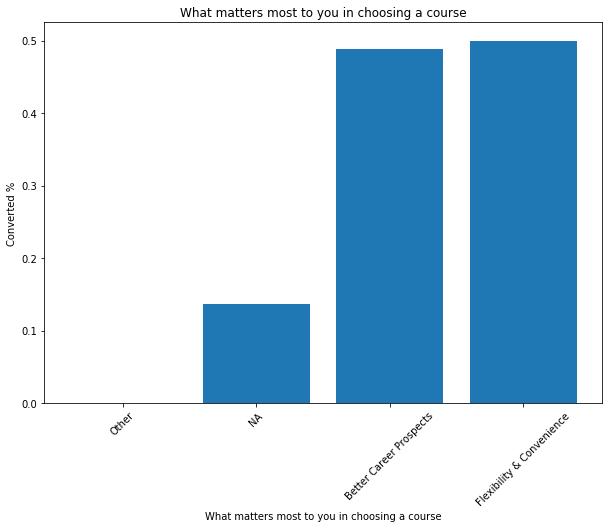

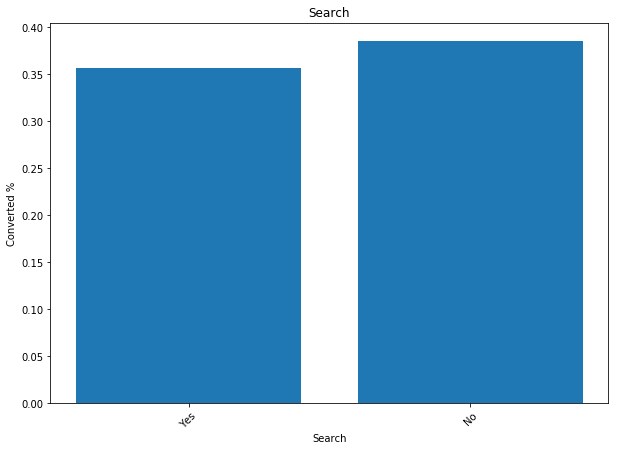

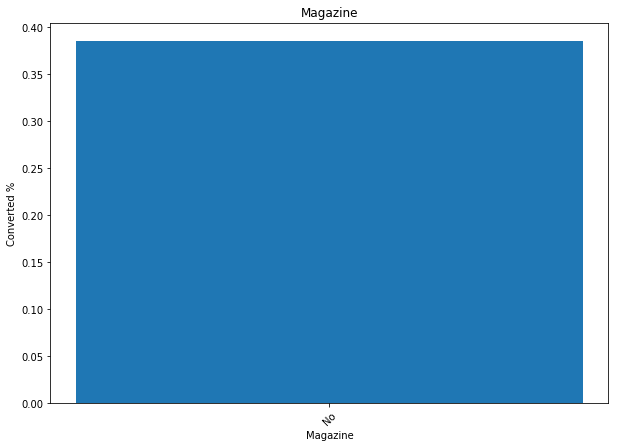

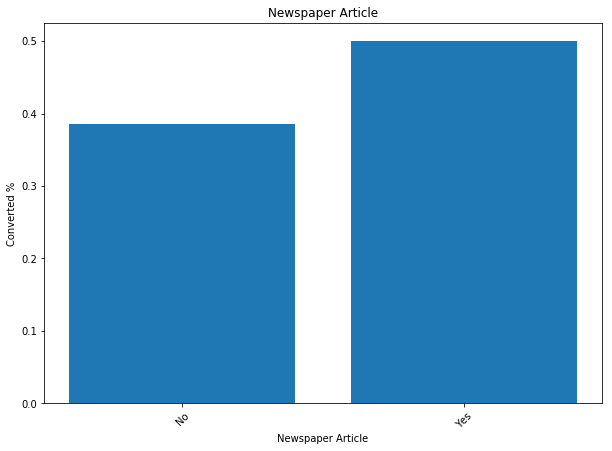

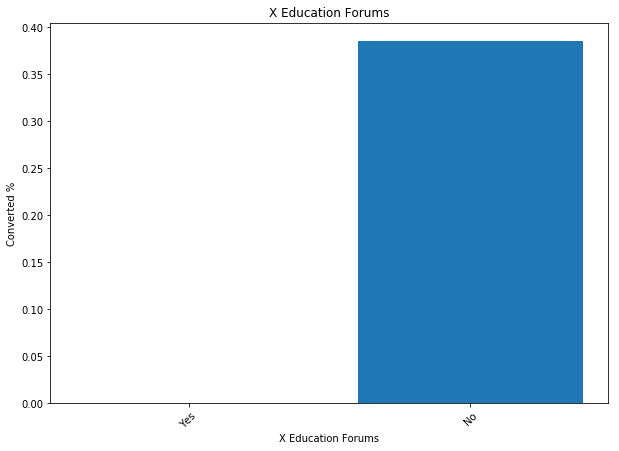

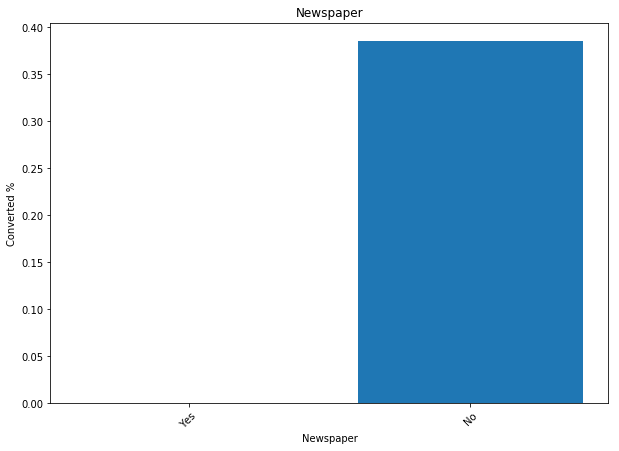

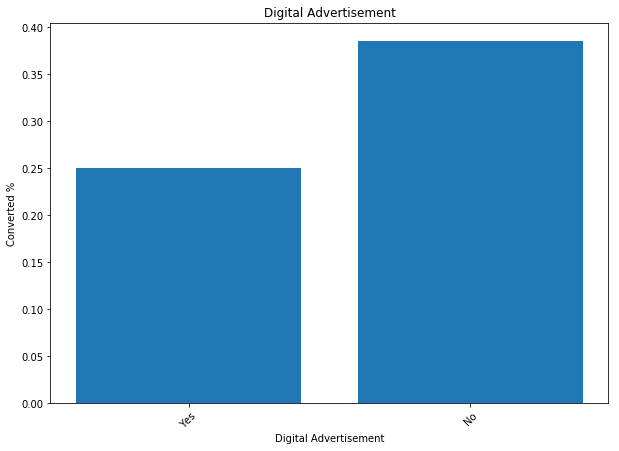

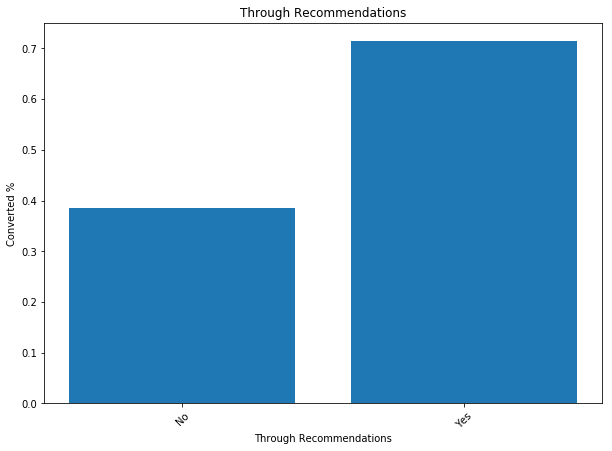

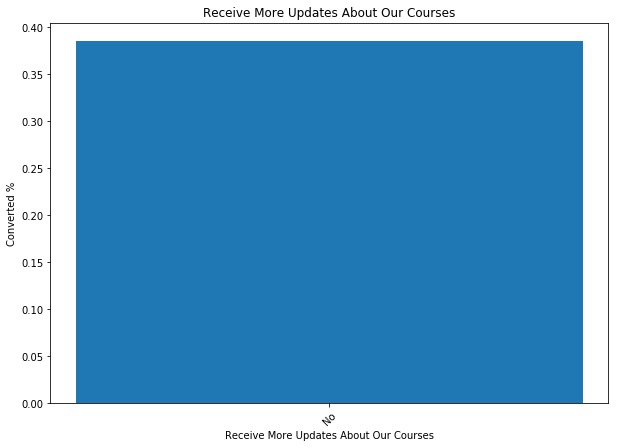

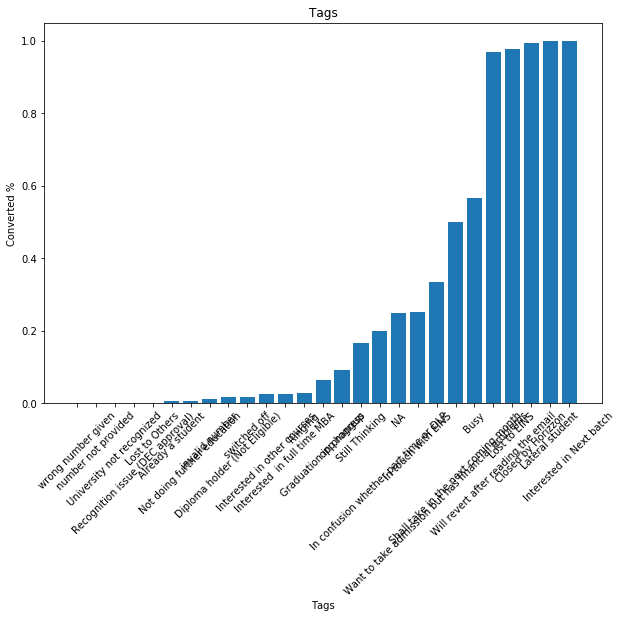

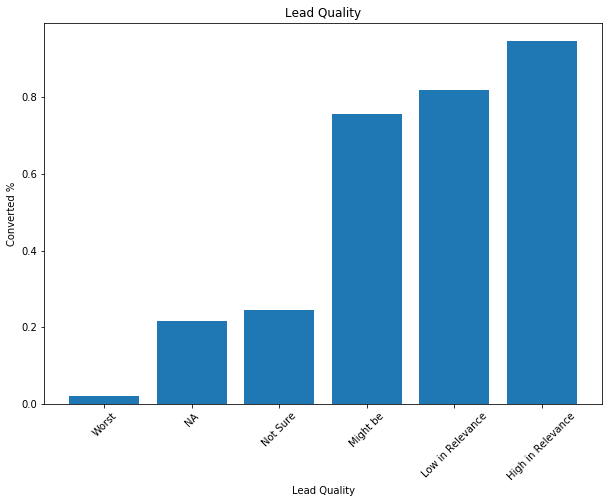

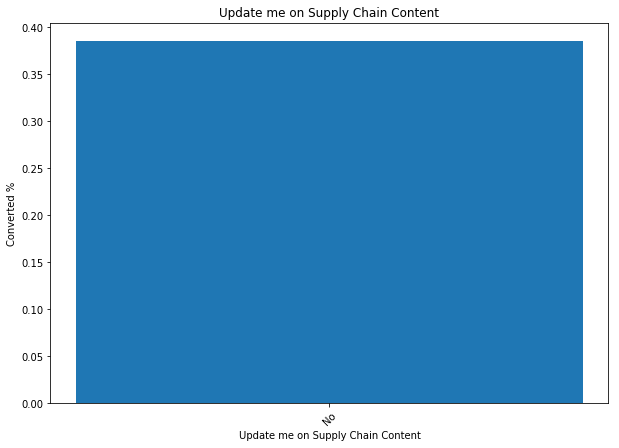

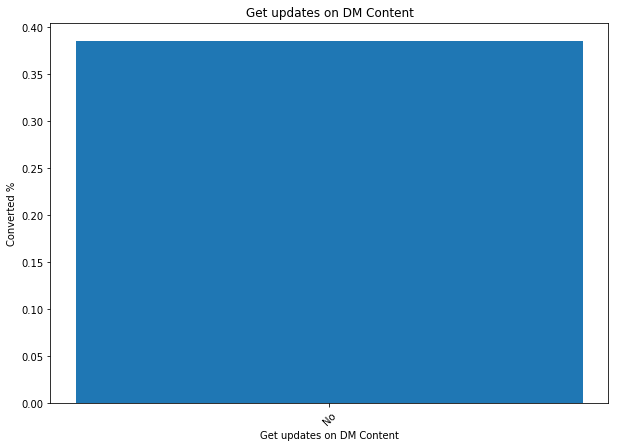

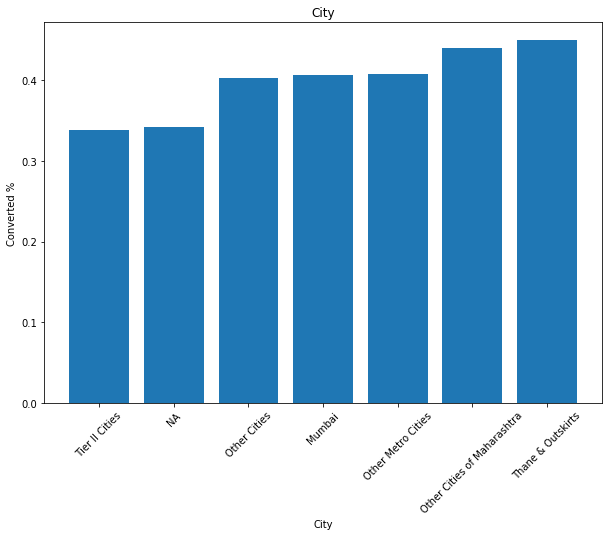

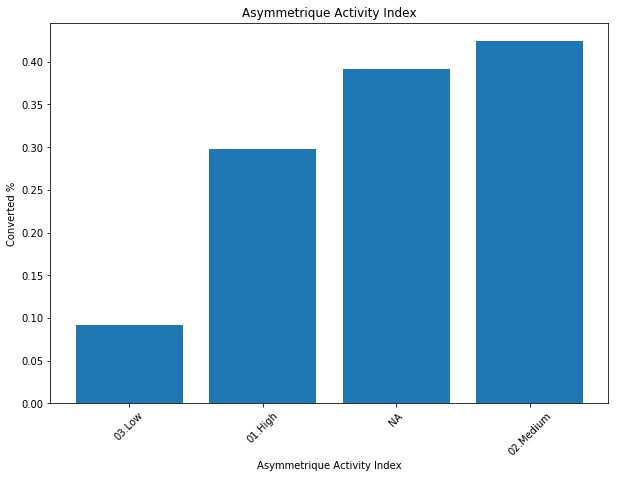

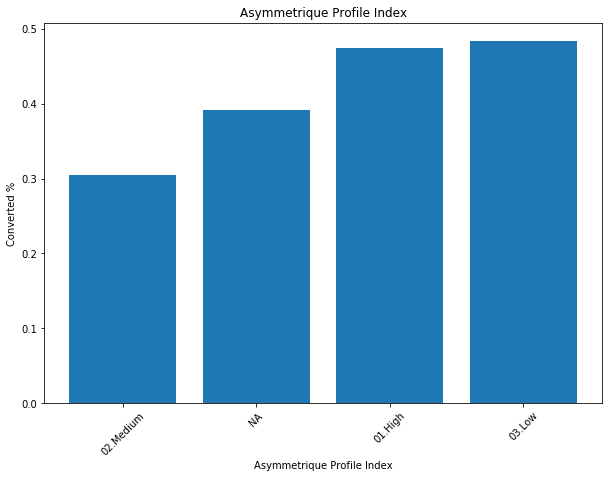

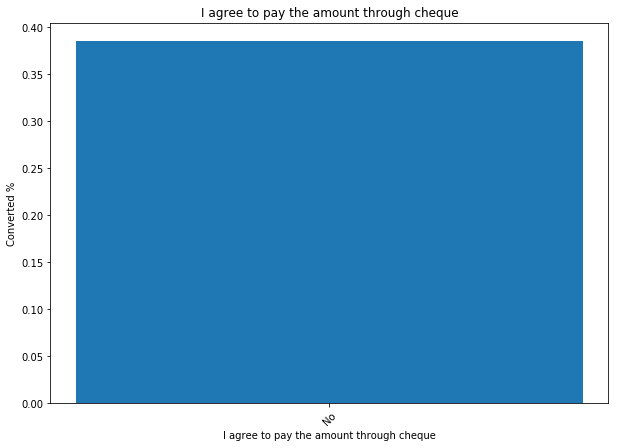

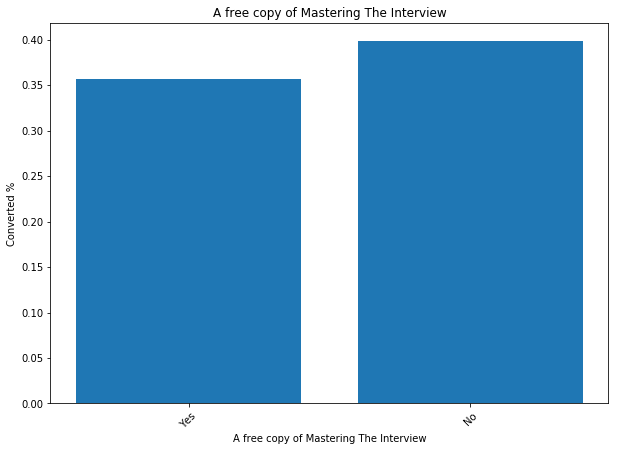

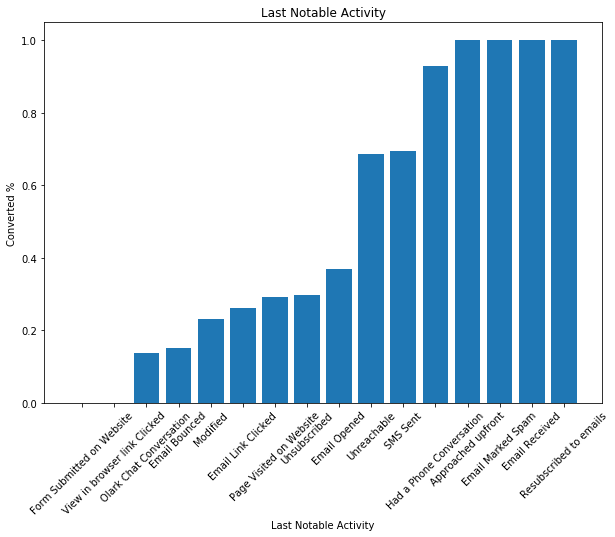

In [21]:
for var in categorical_variables:
    ratio_plots_cat(data, var, 'Converted')

#### Observation:

Variables that can be omitted:
* I agree to pay the amount through cheque : Only one possible level > "No"
* Get updates on DM Content : Only one possible level > "No"
* Receive More Updates About Our Courses : Only one possible level > "No"
* Update me on Supply Chain Content : Only one possible level > "No"
* Magazine : Only one possible level > "No"
* A free copy of Mastering The Interview : Conversion ratio between the 2 possible levels are almost the same
* Search : Conversion ratio between the 2 possible levels are almost the same
* Country : Can be removed as the geographical aspect with relavence is taken care of by the column 'City'

Variables that should be treated:
* Last Notable Activity : Can be recoded
* Specialization : Can be recoded -- drop for now

Variables that do not need any processing:
* Tags
* Lead Origin
* Lead Source
* Do Not Email
* Do Not Call
* What is your current occupation
* What matters most to you in choosing a course
* Newspaper Article
* X Education Forums
* Newspaper
* Digital Advertisement
* Through Recommendations
* Lead Quality
* City
* Asymmetrique Activity Index
* Asymmetrique Profile Index

#### Note: 
In the variable Tags, there is a level 'Diploma holder (Not Eligible)', we could probably eliminate such rows as it is stated in this tag that these candidates are not eligible for the cours.

In [22]:
categorical_variables = ['Lead Origin', 'Lead Source',
       'Do Not Email', 'Do Not Call',
       'What is your current occupation',
       'What matters most to you in choosing a course',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Lead Quality',
       'City', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index',
       'Last Notable Activity','Tags']

### Recoding Of Categorical Variables

In [23]:
last_notable_activity_recoding = {   
    'Modified':'NA',
    'Email Opened':'Viewed Content',
    'Page Visited on Website':'Viewed Content',
    'Email Bounced':'Negative',
    'Email Link Clicked':'Viewed Content',
    'Unreachable':'Negative',
    'Unsubscribed':'Negative',
    'Had a Phone Conversation':'Contacted',
    'Olark Chat Conversation':'Contacted',
    'SMS Sent':'Contacted',
    'Approached upfront':'Positive',
    'Resubscribed to emails':'Positive',
    'View in browser link Clicked':'Positive',
    'Form Submitted on Website':'Positive',
    'Email Received':'Positive',
    'Email Marked Spam':'Negative'
}
pandas.DataFrame([last_notable_activity_recoding]).T.sort_values(0)

,0
Had a Phone Conversation,Contacted
Olark Chat Conversation,Contacted
SMS Sent,Contacted
Modified,NA
Email Bounced,Negative
Email Marked Spam,Negative
Unreachable,Negative
Unsubscribed,Negative
Approached upfront,Positive
Email Received,Positive


In [24]:
data['Last Notable Activity'] = data['Last Notable Activity'].replace(last_notable_activity_recoding)

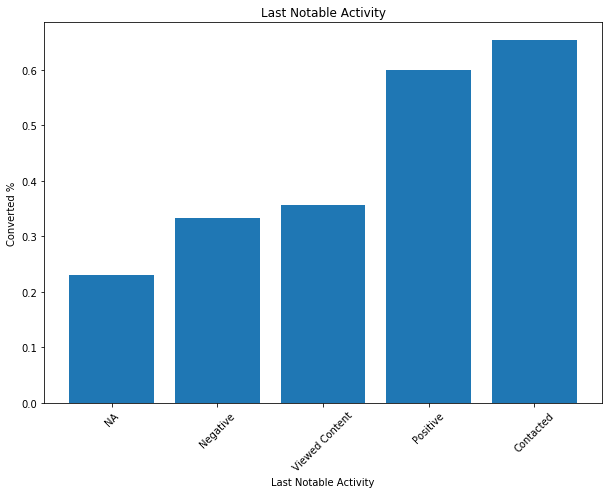

In [25]:
ratio_plots_cat(data, 'Last Notable Activity', 'Converted')

### Distribution & Spread of Conversion Ratio Across Numerical Variables

In [26]:
numerical_variables=['TotalVisits','Asymmetrique Activity Score','Asymmetrique Profile Score',
        'Total Time Spent on Website','Page Views Per Visit']

TotalVisits


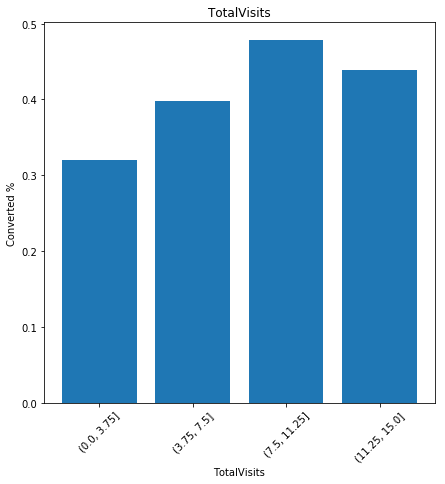

Asymmetrique Activity Score


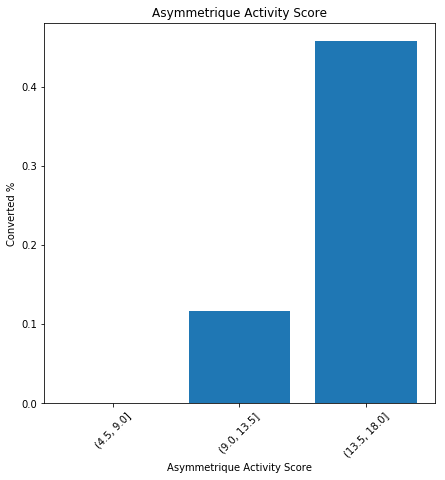

Asymmetrique Profile Score


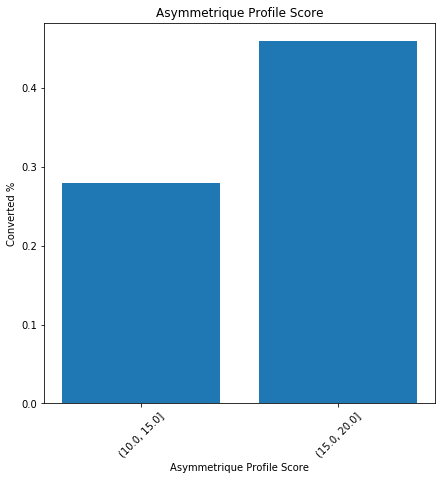

Total Time Spent on Website


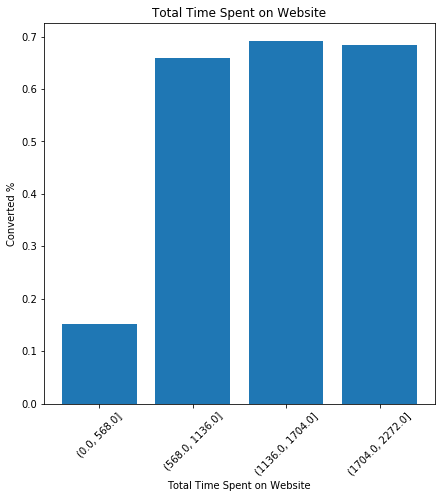

Page Views Per Visit


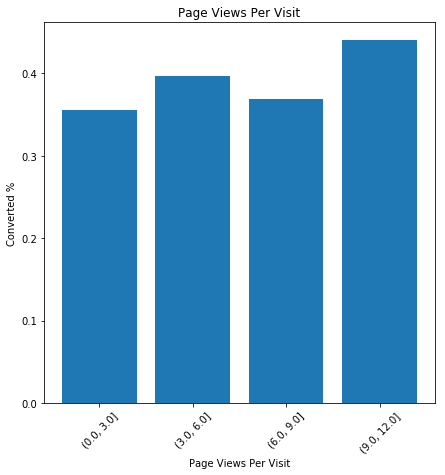

In [27]:
for var in numerical_variables:
    print(var)
    ratio_plots_num(data, var, 'Converted', 4)

#### Observation:
Variable 'Page Views Per Visit' doesnt seem to have much of a relation with conversion whereas the rest of the variables do.

In [28]:
data = data[categorical_variables + numerical_variables + ['Converted']]

### Encoding Categorical Variables

In [29]:
yes_no_encoding_list = ['Do Not Email','Do Not Call','Newspaper Article','X Education Forums','Newspaper','Digital Advertisement','Through Recommendations']
for var in yes_no_encoding_list:
    data[var] = data[var].apply(lambda x:x.lower())
    data[var] = data[var].replace({'yes':1,'no':0})

In [30]:
data = pandas.get_dummies(data, columns=list(set(categorical_variables)-set(yes_no_encoding_list)))

In [31]:
data.columns

Index(['Do Not Email', 'Do Not Call', 'Newspaper Article',
       'X Education Forums', 'Newspaper', 'Digital Advertisement',
       'Through Recommendations', 'TotalVisits', 'Asymmetrique Activity Score',
       'Asymmetrique Profile Score',
       ...
       'Lead Source_Referral Sites', 'Lead Source_Social Media',
       'Lead Source_WeLearn', 'Lead Source_Welingak Website',
       'Lead Source_bing', 'Lead Source_blog', 'Lead Source_google',
       'Lead Source_testone', 'Lead Source_welearnblog_Home',
       'Lead Source_youtubechannel'],
      dtype='object', length=104)

## Correlations

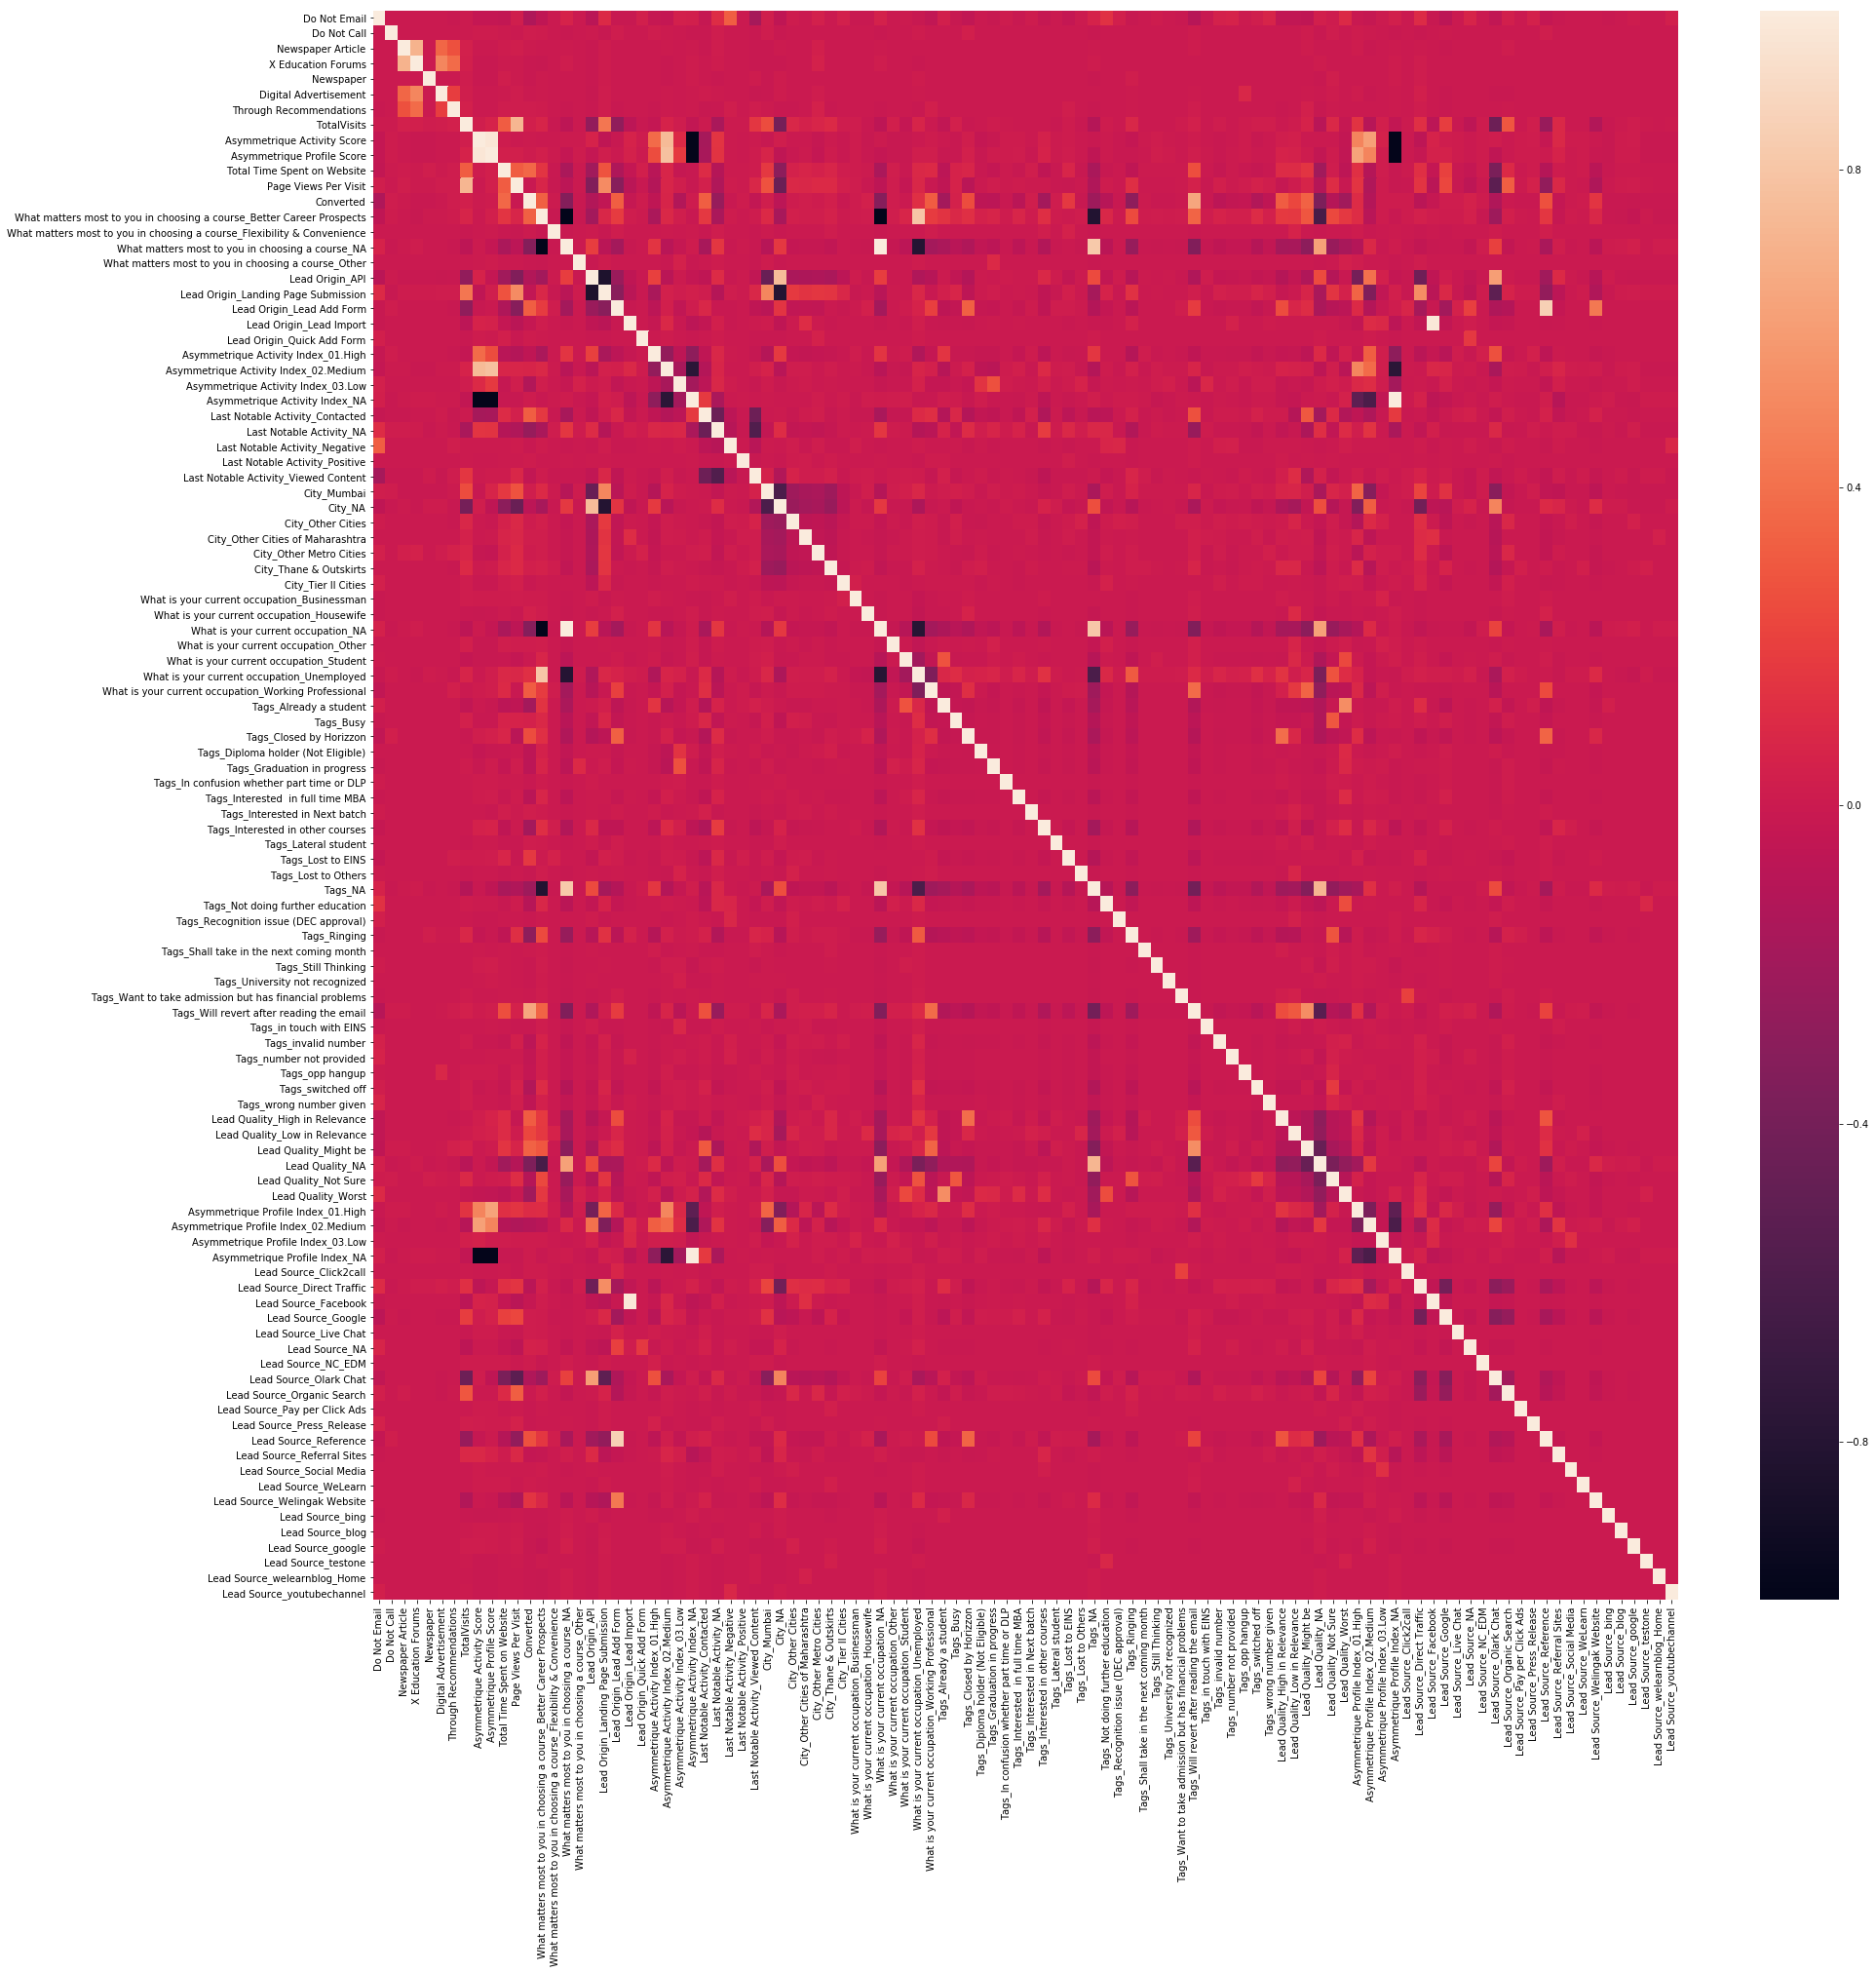

In [32]:
plt.figure(figsize=(30,30))
sns.heatmap(data.corr())

In [33]:
correlations = data.corr().reset_index().melt(id_vars='index')
correlations = correlations.loc[abs(correlations['value'])>0.8]
correlations = correlations.loc[correlations['index'] > correlations['variable']]
correlations = correlations.loc[(correlations['index'] != 'price') & (correlations['variable'] != 'price')]
correlations['key'] = correlations[['index','variable']].apply(lambda x:'_'.join(sorted(x)), axis=1)
correlations = correlations.drop_duplicates(subset=['key'], keep='last')
correlations[['index','variable','value']]

,index,variable,value
841,Asymmetrique Profile Score,Asymmetrique Activity Score,0.973984
913,Asymmetrique Profile Index_NA,Asymmetrique Activity Score,-0.989867
1367,What matters most to you in choosing a course_NA,What matters most to you in choosing a course_...,-0.999217
1786,Lead Origin_Landing Page Submission,Lead Origin_API,-0.842492
2069,Lead Source_Reference,Lead Origin_Lead Add Form,0.853237
2164,Lead Source_Facebook,Lead Origin_Lead Import,0.981709
2608,Asymmetrique Activity Score,Asymmetrique Activity Index_NA,-0.989867
2609,Asymmetrique Profile Score,Asymmetrique Activity Index_NA,-0.986816
2681,Asymmetrique Profile Index_NA,Asymmetrique Activity Index_NA,1.000000
3346,Lead Origin_Landing Page Submission,City_NA,-0.808285


#### Observations:

We can remove the following variables as they have high correlation with another variable:
* Asymmetrique Profile Score

We can also remove the columns for the level 'NA' for all the encoded variables.

In [34]:
data.columns.values

array(['Do Not Email', 'Do Not Call', 'Newspaper Article',
       'X Education Forums', 'Newspaper', 'Digital Advertisement',
       'Through Recommendations', 'TotalVisits',
       'Asymmetrique Activity Score', 'Asymmetrique Profile Score',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Converted',
       'What matters most to you in choosing a course_Better Career Prospects',
       'What matters most to you in choosing a course_Flexibility & Convenience',
       'What matters most to you in choosing a course_NA',
       'What matters most to you in choosing a course_Other',
       'Lead Origin_API', 'Lead Origin_Landing Page Submission',
       'Lead Origin_Lead Add Form', 'Lead Origin_Lead Import',
       'Lead Origin_Quick Add Form',
       'Asymmetrique Activity Index_01.High',
       'Asymmetrique Activity Index_02.Medium',
       'Asymmetrique Activity Index_03.Low',
       'Asymmetrique Activity Index_NA',
       'Last Notable Activity_Contacted', 'Last Notabl

In [35]:
target = 'Converted'
features_set_1 = ['Do Not Email', 'Do Not Call', 'Newspaper Article',
       'X Education Forums', 'Newspaper', 'Digital Advertisement',
       'Through Recommendations', 'TotalVisits',
       'Asymmetrique Activity Score', 'Asymmetrique Profile Score',
       'Total Time Spent on Website', 'Page Views Per Visit', 
       'Last Notable Activity_Contacted',
       'Last Notable Activity_Negative', 'Last Notable Activity_Positive',
       'Last Notable Activity_Viewed Content',
       'What is your current occupation_Businessman',
       'What is your current occupation_Housewife',
       'What is your current occupation_Other',
       'What is your current occupation_Student',
       'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional',
       'Lead Source_Click2call', 'Lead Source_Direct Traffic',
       'Lead Source_Facebook', 'Lead Source_Google',
       'Lead Source_Live Chat', 'Lead Source_NC_EDM',
       'Lead Source_Olark Chat', 'Lead Source_Organic Search',
       'Lead Source_Pay per Click Ads', 'Lead Source_Press_Release',
       'Lead Source_Reference', 'Lead Source_Referral Sites',
       'Lead Source_Social Media', 'Lead Source_WeLearn',
       'Lead Source_Welingak Website', 'Lead Source_bing',
       'Lead Source_blog', 'Lead Source_google', 'Lead Source_testone',
       'Lead Source_welearnblog_Home', 'Lead Source_youtubechannel',
       'What matters most to you in choosing a course_Better Career Prospects',
       'What matters most to you in choosing a course_Flexibility & Convenience',
       'What matters most to you in choosing a course_Other',
       'Lead Quality_High in Relevance', 'Lead Quality_Low in Relevance',
       'Lead Quality_Might be',
       'Lead Quality_Not Sure', 'Lead Quality_Worst',
       'Asymmetrique Activity Index_01.High',
       'Asymmetrique Activity Index_02.Medium',
       'Asymmetrique Activity Index_03.Low',
       'City_Mumbai', 
       'City_Other Cities', 'City_Other Cities of Maharashtra',
       'City_Other Metro Cities', 'City_Thane & Outskirts',
       'City_Tier II Cities', 'Asymmetrique Profile Index_01.High',
       'Asymmetrique Profile Index_02.Medium',
       'Asymmetrique Profile Index_03.Low',
       'Tags_Already a student',
       'Tags_Busy', 'Tags_Closed by Horizzon',
       'Tags_Diploma holder (Not Eligible)',
       'Tags_Graduation in progress',
       'Tags_In confusion whether part time or DLP',
       'Tags_Interested  in full time MBA',
       'Tags_Interested in Next batch',
       'Tags_Interested in other courses', 'Tags_Lateral student',
       'Tags_Lost to EINS', 'Tags_Lost to Others', 
       'Tags_Not doing further education',
       'Tags_Recognition issue (DEC approval)', 'Tags_Ringing',
       'Tags_Shall take in the next coming month', 'Tags_Still Thinking',
       'Tags_University not recognized',
       'Tags_Want to take admission but has financial problems',
       'Tags_Will revert after reading the email',
       'Tags_in touch with EINS', 'Tags_invalid number',
       'Tags_number not provided', 'Tags_opp hangup', 'Tags_switched off',
       'Tags_wrong number given', 'Lead Origin_API',
       'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Add Form',
       'Lead Origin_Lead Import', 'Lead Origin_Quick Add Form']

### Train Test Split

In [36]:
numpy.random.seed(0)
df_train, df_test = train_test_split(data, train_size = 0.7, test_size = 0.3, random_state = 100)

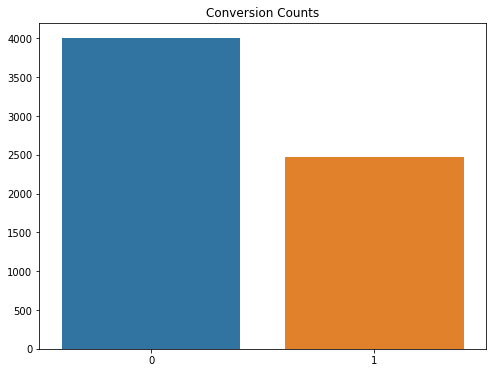

In [37]:
plt.figure(figsize=(8,6))
plt.title('Conversion Counts')
sns.barplot(x=df_train['Converted'].value_counts().index, y=[df_train['Converted'].value_counts()[0], df_train['Converted'].value_counts()[1]],orient='v')

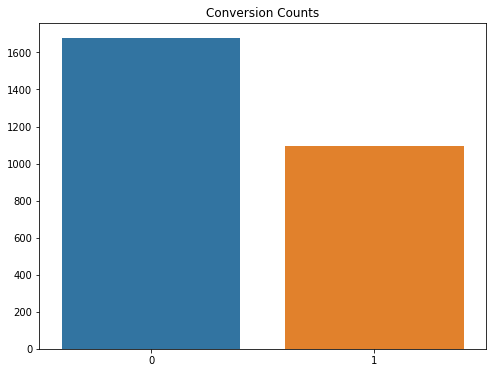

In [38]:
plt.figure(figsize=(8,6))
plt.title('Conversion Counts')
sns.barplot(x=df_test['Converted'].value_counts().index, y=[df_test['Converted'].value_counts()[0], df_test['Converted'].value_counts()[1]],orient='v')

### Scaling Numerical Variables

In [39]:
scaler = MinMaxScaler()

num_vars = list(set(data.columns) & set(numerical_variables) )

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

y_train = df_train.pop(target)
X_train = df_train

y_test = df_test.pop(target)
X_test = df_test

## Model Building

### Iteration 1: VIF To Eliminate Features

In [40]:
lm = LinearRegression()
lm.fit(X_train[features_set_1], y_train)

rfe = RFE(lm, 30)
rfe = rfe.fit(X_train[features_set_1], y_train)

variables = list(zip(X_train[features_set_1],rfe.support_,rfe.ranking_))
ref_result = [x[0] for x in variables if x[1]==True]
ref_result

['Asymmetrique Activity Score',
 'Lead Source_NC_EDM',
 'What matters most to you in choosing a course_Better Career Prospects',
 'What matters most to you in choosing a course_Flexibility & Convenience',
 'What matters most to you in choosing a course_Other',
 'Asymmetrique Activity Index_01.High',
 'Asymmetrique Activity Index_02.Medium',
 'Asymmetrique Activity Index_03.Low',
 'Asymmetrique Profile Index_01.High',
 'Asymmetrique Profile Index_02.Medium',
 'Asymmetrique Profile Index_03.Low',
 'Tags_Already a student',
 'Tags_Closed by Horizzon',
 'Tags_Diploma holder (Not Eligible)',
 'Tags_Graduation in progress',
 'Tags_Interested  in full time MBA',
 'Tags_Interested in Next batch',
 'Tags_Interested in other courses',
 'Tags_Lateral student',
 'Tags_Lost to EINS',
 'Tags_Lost to Others',
 'Tags_Not doing further education',
 'Tags_Recognition issue (DEC approval)',
 'Tags_Ringing',
 'Tags_Shall take in the next coming month',
 'Tags_Will revert after reading the email',
 'Tags_i

#### Observation
We can bring down the total number of features through RFE to 30 and carry forward from here

### Iteration 2

In [41]:
features_set_2 = ref_result

In [42]:
features = features_set_2

X_train_sm = sm.add_constant(X_train[features])
X_test_sm = sm.add_constant(X_test[features])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
model = logm2.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6438
Model Family:                Binomial   Df Model:                           29
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 02 Mar 2020   Deviance:                          nan
Time:                        18:36:49   Pearson chi2:                 3.34e+18
No. Iterations:                   100   Covariance Type:             nonrobust
===========================================================================================================================================
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------
const                                                                   -2.731e+15    1.8e+06  -1.52e+09      0.000   -2.73e+15   -2.73e+15
Asymmetrique Activity Score                                              7.073e+15   2.98e+07   2.38e+08      0.000    7.07e+15    7.07e+15
Lead Source_NC_EDM                                                       1.419e+15   6.72e+07   2.11e+07      0.000    1.42e+15    1.42e+15
What matters most to you in choosing a course_Better Career Prospects    1.641e+15    2.9e+06   5.66e+08      0.000    1.64e+15    1.64e+15
What matters most to you in choosing a course_Flexibility & Convenience   3.26e+14   4.77e+07   6.84e+06      0.000    3.26e+14    3.26e+14
What matters most to you in choosing a course_Other                     -4.881e+14   6.77e+07  -7.21e+06      0.000   -4.88e+14   -4.88e+14
Asymmetrique Activity Index_01.High                                     -2.329e+15   1.59e+07  -1.47e+08      0.000   -2.33e+15   -2.33e+15
Asymmetrique Activity Index_02.Medium                                   -2.654e+15   1.21e+07  -2.19e+08      0.000   -2.65e+15   -2.65e+15
Asymmetrique Activity Index_03.Low                                      -2.482e+15   8.52e+06  -2.91e+08      0.000   -2.48e+15   -2.48e+15
Asymmetrique Profile Index_01.High                                      -2.642e+15   1.19e+07  -2.22e+08      0.000   -2.64e+15   -2.64e+15
Asymmetrique Profile Index_02.Medium                                    -2.646e+15   1.21e+07  -2.19e+08      0.000   -2.65e+15   -2.65e+15
Asymmetrique Profile Index_03.Low                                       -2.178e+15   1.66e+07  -1.31e+08      0.000   -2.18e+15   -2.18e+15
Tags_Already a student                                                   -2.08e+15   4.54e+06  -4.59e+08      0.000   -2.08e+15   -2.08e+15
Tags_Closed by Horizzon                                                  2.139e+15   5.03e+06   4.26e+08      0.000    2.14e+15    2.14e+15
Tags_Diploma holder (Not Eligible)                                      -3.099e+15   1.02e+07  -3.03e+08      0.000    -3.1e+15    -3.1e+15
Tags_Graduation in progress                                             -4.826e+14   8.96e+06  -5.39e+07      0.000   -4.83e+14   -4.83e+14
Tags_Interested  in full time MBA                                       -2.511e+14   7.88e+06  -3.19e+07      0.000   -2.51e+14   -2.51e+14
Tags_Interested in Next batch                                             4.39e+15   3.01e+07   1.46e+08      0.000    4.39e+15    4.39e+15
Tags_Interested in other courses                                         1.403e+14   4.24e+06   3.31e+07      0.000     1.4e+14     1.4e+14
Tags_Lateral student                                                     3.827e+15

In [43]:
predict_summarize(X_train_sm, y_train, model, 0.5)

Accuracy =  0.8854359925788498
Sensitivity =  0.7283049472830495
Specificity =  0.9822588705647176
False Positive Rate =  0.01774112943528236

Precision =  0.9619710765934655
Recall =  0.7283049472830495


,predicted_no,predicted_yes
ind,,
actual_no,3931,71
actual_yes,670,1796


In [44]:
predict_summarize(X_test_sm, y_test, model, 0.5)

Accuracy =  0.5995670995670995
Sensitivity =  0.8484018264840183
Specificity =  0.4370900417412045
False Positive Rate =  0.5629099582587954

Precision =  0.49599572877736253
Recall =  0.8484018264840183


,predicted_no,predicted_yes
ind,,
actual_no,733,944
actual_yes,166,929


#### Observation: 
It clearly seems that the model has overfit to the data so we can start removing insignificant variables.

### Iteration 3

In [45]:
vif_ranks(X_train_sm, features, 10)

,Features,VIF
5,Asymmetrique Activity Index_01.High,inf
6,Asymmetrique Activity Index_02.Medium,inf
7,Asymmetrique Activity Index_03.Low,inf
8,Asymmetrique Profile Index_01.High,inf
9,Asymmetrique Profile Index_02.Medium,inf
10,Asymmetrique Profile Index_03.Low,inf
0,Asymmetrique Activity Score,438.60
2,What matters most to you in choosing a course_...,6.90
25,Tags_Will revert after reading the email,3.09
23,Tags_Ringing,2.23


In [46]:
exclude_vars = ['Asymmetrique Activity Index_01.High',
       'Asymmetrique Activity Index_02.Medium',
       'Asymmetrique Activity Index_03.Low',
       'Asymmetrique Profile Index_01.High',
       'Asymmetrique Profile Index_02.Medium',
       'Asymmetrique Profile Index_03.Low', 'Asymmetrique Activity Score']

In [47]:
features_set_3 = list(set(features_set_2)-set(exclude_vars))

In [48]:
features = features_set_3

X_train_sm = sm.add_constant(X_train[features])
X_test_sm = sm.add_constant(X_test[features])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
model = logm2.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6444
Model Family:                Binomial   Df Model:                           23
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1591.0
Date:                Mon, 02 Mar 2020   Deviance:                       3182.1
Time:                        18:36:51   Pearson chi2:                 6.72e+03
No. Iterations:                    23   Covariance Type:             nonrobust
===========================================================================================================================================
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------
const                                                                      -1.9398      0.070    -27.626      0.000      -2.077      -1.802
Tags_Graduation in progress                                                -3.0530      0.472     -6.468      0.000      -3.978      -2.128
Tags_wrong number given                                                   -25.1177   2.35e+04     -0.001      0.999   -4.61e+04    4.61e+04
What matters most to you in choosing a course_Other                       -19.5733   1.31e+05     -0.000      1.000   -2.57e+05    2.57e+05
Tags_Diploma holder (Not Eligible)                                        -25.1177   1.91e+04     -0.001      0.999   -3.75e+04    3.74e+04
Tags_invalid number                                                        -4.6625      1.011     -4.610      0.000      -6.645      -2.680
Tags_Recognition issue (DEC approval)                                     -25.1177   1.31e+05     -0.000      1.000   -2.57e+05    2.57e+05
Tags_Will revert after reading the email                                    2.8781      0.171     16.801      0.000       2.542       3.214
Tags_Interested in Next batch                                              24.0145   5.86e+04      0.000      1.000   -1.15e+05    1.15e+05
Tags_Lost to EINS                                                           4.9537      0.725      6.830      0.000       3.532       6.375
Tags_Ringing                                                               -4.0444      0.218    -18.534      0.000      -4.472      -3.617
What matters most to you in choosing a course_Flexibility & Convenience     1.4432      6.655      0.217      0.828     -11.599      14.486
Tags_Closed by Horizzon                                                     4.9537      1.005      4.928      0.000       2.984       6.924
Tags_Not doing further education                                           -5.2337      1.008     -5.193      0.000      -7.209      -3.258
What matters most to you in choosing a course_Better Career Prospects       2.4914      0.106     23.424      0.000       2.283       2.700
Tags_Already a student                                                     -5.6453      0.714     -7.909      0.000      -7.044      -4.246
Tags_Interested  in full time MBA                                          -4.2279      0.720     -5.868      0.000      -5.640      -2.816
Tags_Lost to Others                                                       -25.1177   5.86e+04     -0.000      1.000   -1.15e+05    1.15e+05
Tags_switched off                                                          -4.3414      0.512     -8.481      0.000      -5.345      -3.338
Lead Source_NC_EDM                                                         26.5058

In [49]:
predict_summarize(X_train_sm, y_train, model, 0.5)

Accuracy =  0.9111008039579468
Sensitivity =  0.8852392538523925
Specificity =  0.9270364817591205
False Positive Rate =  0.07296351824087956

Precision =  0.882020202020202
Recall =  0.8852392538523925


,predicted_no,predicted_yes
ind,,
actual_no,3710,292
actual_yes,283,2183


In [50]:
predict_summarize(X_test_sm, y_test, model, 0.5)

Accuracy =  0.9173881673881674
Sensitivity =  0.902283105022831
Specificity =  0.9272510435301133
False Positive Rate =  0.0727489564698867

Precision =  0.8900900900900901
Recall =  0.902283105022831


,predicted_no,predicted_yes
ind,,
actual_no,1555,122
actual_yes,107,988


### Iteration 4

In [51]:
vif_ranks(X_train_sm, features, 10)

,Features,VIF
11,Tags_Closed by Horizzon,1.34
17,Tags_switched off,1.25
12,Tags_Not doing further education,1.15
15,Tags_Interested in full time MBA,1.11
0,Tags_Graduation in progress,1.11
4,Tags_invalid number,1.09
8,Tags_Lost to EINS,1.08
3,Tags_Diploma holder (Not Eligible),1.07
1,Tags_wrong number given,1.04
22,Tags_opp hangup,1.03


#### Observation:
The VIF values are not very high so we can stop the elimination through VIF. However, we can eliminate variables based on the p value in the last iteration.

In [52]:
exclude_vars = [
    'What matters most to you in choosing a course_Other',
    'Tags_Recognition issue (DEC approval)',
    'Tags_Lost to Others',
    'Lead Source_NC_EDM',
    'Tags_Shall take in the next coming month',
    'Tags_Lateral student',
    'Tags_Interested in Next batch'
]

features_set_4 = list(set(features_set_3)-set(exclude_vars))

In [53]:
features = features_set_4

X_train_sm = sm.add_constant(X_train[features])
X_test_sm = sm.add_constant(X_test[features])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
model = logm2.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6451
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1603.2
Date:                Mon, 02 Mar 2020   Deviance:                       3206.5
Time:                        18:36:52   Pearson chi2:                 6.73e+03
No. Iterations:                    23   Covariance Type:             nonrobust
===========================================================================================================================================
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------
const                                                                      -1.9355      0.070    -27.618      0.000      -2.073      -1.798
Tags_Graduation in progress                                                -3.0513      0.472     -6.467      0.000      -3.976      -2.127
Tags_Will revert after reading the email                                    2.8813      0.171     16.861      0.000       2.546       3.216
Tags_Closed by Horizzon                                                     4.9569      1.005      4.932      0.000       2.987       6.927
Tags_Not doing further education                                           -5.2305      1.008     -5.190      0.000      -7.206      -3.255
Tags_switched off                                                          -4.3383      0.512     -8.477      0.000      -5.341      -3.335
Tags_wrong number given                                                   -25.1145   2.35e+04     -0.001      0.999   -4.61e+04    4.61e+04
What matters most to you in choosing a course_Better Career Prospects       2.4839      0.106     23.524      0.000       2.277       2.691
Tags_Already a student                                                     -5.6421      0.714     -7.906      0.000      -7.041      -4.243
Tags_Interested  in full time MBA                                          -4.2247      0.720     -5.865      0.000      -5.637      -2.813
Tags_Lost to EINS                                                           4.9506      0.725      6.826      0.000       3.529       6.372
Tags_Interested in other courses                                           -3.9574      0.316    -12.507      0.000      -4.578      -3.337
Tags_Diploma holder (Not Eligible)                                        -25.1145   1.91e+04     -0.001      0.999   -3.75e+04    3.74e+04
Tags_invalid number                                                        -4.6593      1.011     -4.607      0.000      -6.641      -2.677
Tags_Ringing                                                               -4.0413      0.218    -18.548      0.000      -4.468      -3.614
Tags_opp hangup                                                            -2.8998      0.744     -3.896      0.000      -4.358      -1.441
What matters most to you in choosing a course_Flexibility & Convenience     1.4389      6.645      0.217      0.829     -11.584      14.462
===========================================================================================================================================
"""

In [54]:
predict_summarize(X_train_sm, y_train, model, 0.5)

Accuracy =  0.9100185528756958
Sensitivity =  0.8848337388483374
Specificity =  0.9255372313843079
False Positive Rate =  0.07446276861569215

Precision =  0.8798387096774194
Recall =  0.8848337388483374


,predicted_no,predicted_yes
ind,,
actual_no,3704,298
actual_yes,284,2182


In [55]:
predict_summarize(X_test_sm, y_test, model, 0.5)

Accuracy =  0.9166666666666666
Sensitivity =  0.902283105022831
Specificity =  0.9260584376863447
False Positive Rate =  0.07394156231365534

Precision =  0.8884892086330936
Recall =  0.902283105022831


,predicted_no,predicted_yes
ind,,
actual_no,1553,124
actual_yes,107,988


### Iteration 5

In [56]:
exclude_vars = [
    'Tags_wrong number given',
    'Tags_Diploma holder (Not Eligible)',
    'What matters most to you in choosing a course_Flexibility & Convenience'
]

features_set_5 = list(set(features_set_4)-set(exclude_vars))

In [57]:
features = features_set_5

X_train_sm = sm.add_constant(X_train[features])
X_test_sm = sm.add_constant(X_test[features])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
model = logm2.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6454
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1674.9
Date:                Mon, 02 Mar 2020   Deviance:                       3349.8
Time:                        18:36:54   Pearson chi2:                 6.72e+03
No. Iterations:                     8   Covariance Type:             nonrobust
=========================================================================================================================================
                                                                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
const                                                                    -1.9359      0.070    -27.624      0.000      -2.073      -1.799
Tags_Graduation in progress                                              -2.7822      0.471     -5.910      0.000      -3.705      -1.859
Tags_Closed by Horizzon                                                   5.2265      1.005      5.202      0.000       3.257       7.196
Tags_Not doing further education                                         -4.9609      1.007     -4.925      0.000      -6.935      -2.987
What matters most to you in choosing a course_Better Career Prospects     2.2147      0.101     21.919      0.000       2.017       2.413
Tags_Already a student                                                   -5.3726      0.713     -7.535      0.000      -6.770      -3.975
Tags_Interested  in full time MBA                                        -3.9551      0.720     -5.495      0.000      -5.366      -2.545
Tags_invalid number                                                      -4.3897      1.011     -4.343      0.000      -6.371      -2.409
Tags_Will revert after reading the email                                  3.1509      0.168     18.743      0.000       2.821       3.480
Tags_switched off                                                        -4.0687      0.511     -7.964      0.000      -5.070      -3.067
Tags_Lost to EINS                                                         5.0161      0.723      6.940      0.000       3.599       6.433
Tags_Interested in other courses                                         -3.6892      0.315    -11.718      0.000      -4.306      -3.072
Tags_Ringing                                                             -3.7717      0.216    -17.484      0.000      -4.194      -3.349
Tags_opp hangup                                                          -2.6302      0.744     -3.537      0.000      -4.088      -1.173
=========================================================================================================================================
"""

Accuracy =  0.8979591836734694
Sensitivity =  0.8848337388483374
Specificity =  0.9060469765117442
False Positive Rate =  0.09395302348825588

Precision =  0.853010164190774
Recall =  0.8848337388483374
Plotting


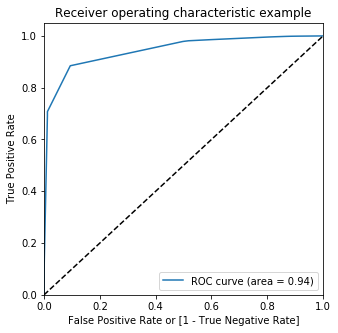

,predicted_no,predicted_yes
ind,,
actual_no,3626,376
actual_yes,284,2182


In [58]:
predict_summarize(X_train_sm, y_train, model, 0.5, True)

In [59]:
predict_summarize(X_test_sm, y_test, model, 0.5)

Accuracy =  0.9058441558441559
Sensitivity =  0.9031963470319635
Specificity =  0.9075730471079309
False Positive Rate =  0.09242695289206918

Precision =  0.8645104895104895
Recall =  0.9031963470319635


,predicted_no,predicted_yes
ind,,
actual_no,1522,155
actual_yes,106,989


#### Observation:
We have been able to reduce the variables to a considarable level and attain a good accuracy. We can now freeze the set of features and try to tune the threshold to be able to set an appropriate value which optimizes precision and recall.

### Threshold Tuning

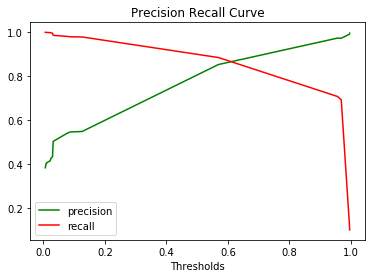

In [60]:
plot_precision_recall_curve(X_train_sm, y_train, model)

Accuracy =  0.8811069882498453
Sensitivity =  0.7076236820762368
Specificity =  0.9880059970014993
False Positive Rate =  0.01199400299850075

Precision =  0.9732292247629671
Recall =  0.7076236820762368
Plotting


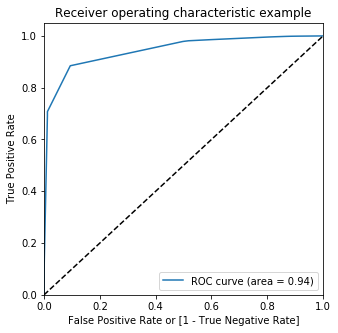

,predicted_no,predicted_yes
ind,,
actual_no,3954,48
actual_yes,721,1745


In [61]:
predict_summarize(X_train_sm, y_train, model, 0.6, True)

In [62]:
predict_summarize(X_test_sm, y_test, model, 0.6)

Accuracy =  0.8813131313131313
Sensitivity =  0.7205479452054795
Specificity =  0.9862850327966607
False Positive Rate =  0.013714967203339297

Precision =  0.9716748768472906
Recall =  0.7205479452054795


,predicted_no,predicted_yes
ind,,
actual_no,1654,23
actual_yes,306,789


#### Observation:
In this problen it is more important to have a higher precision than recall as it is more important to reduce number of false positives than false negatives as if you have a high number of false positives, that is, the model predicted leads who actually would not be potentially converted as a hot lead, then the counselors are actually wasting their time in concentrating on leads who are not beneficial and leaving out the actual hot leads. This might cause a huge loss in the overall conversion.

This iteration of the model has performed very well and consistently as it has good precision and accuracy on the train and test set both.

KS of 78.43 in decile = 3


,decile,converted_count,total_count,min_prob,max_prob,event_rate,non_event_rate,cum_event_rate,cum_non_event_rate,KS
0,0,631,647,0.968619,0.995951,25.59,0.40,25.59,0.40,25.19
1,1,629,647,0.968619,0.968619,25.51,0.45,51.10,0.85,50.25
2,2,581,647,0.569255,0.968619,23.56,1.65,74.66,2.50,72.16
3,3,342,646,0.126095,0.569255,13.87,7.60,88.53,10.10,78.43
4,4,77,647,0.126095,0.126095,3.12,14.24,91.65,24.34,67.31
5,5,85,647,0.126095,0.126095,3.45,14.04,95.10,38.38,56.72
6,6,76,646,0.031974,0.126095,3.08,14.24,98.18,52.62,45.56
7,7,20,647,0.029516,0.031974,0.81,15.67,98.99,68.29,30.70
8,8,18,647,0.022099,0.029516,0.73,15.72,99.72,84.01,15.71
9,9,7,647,0.003593,0.022099,0.28,15.99,100.00,100.00,0.00


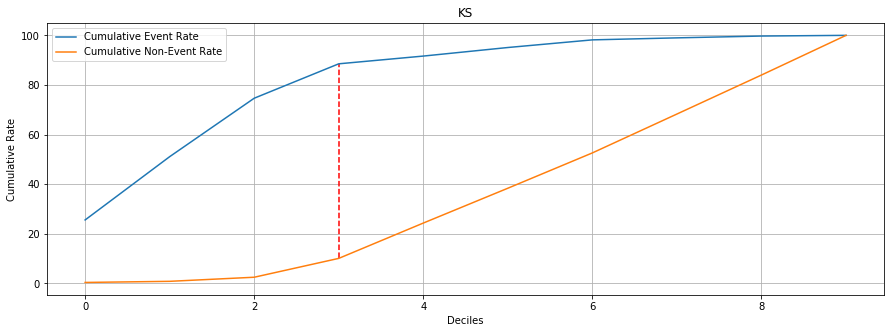

In [63]:
ks_metric(X_train_sm, y_train, model, 0.6)

#### Observation:
We can see that as per the probability cutoff that we have taken as 0.6, we get the best precision. This section of the data is covered in the top 3 deciles itself. However, if there is time left out for the team, it is possible to consider the next best set of the leads, that is the 4th decile, only if it is worth it. In the KS Chart above, we can clearly see that the 4th decile also gives a good or atleast a decent conversion rate, post which, from the 5th decile, the conversion rate drops drastically. So even if the team completes following up on the leads as per the threshold of 0.6, we can push the team to only pursue the next set of 10% of leads only and not further than that as the conversion rate drops as low as 3% post the 4th decile.

### Feature Importance

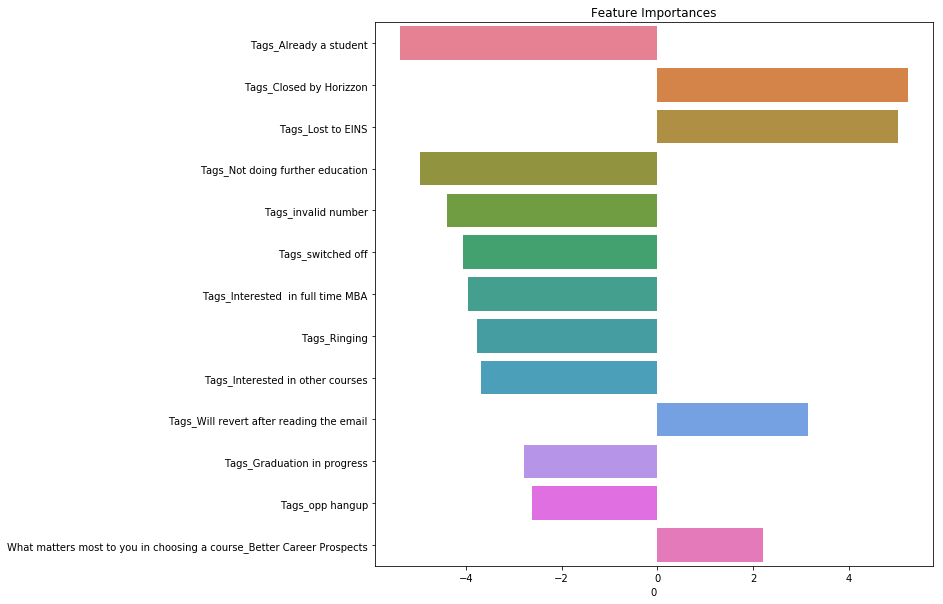

In [64]:
plot_feature_importance(model)

#### Observation:
We can see that the Tag variable has a significant impact on whether or not the lead will get converted and the below are the most impacting inferences.

When
* Tag = Already a student, the probability of the lead getting converted reduces.
* Tag = Closed by Horizzon, the probability of the lead getting converted increases.
* Tag = Lost to EINS, the probability of the lead getting converted increases.
* Tag = Not doing further education, the probability of the lead getting converted reduces.

# Conclusion

The top important variables in understanding if the lead will get converted or not are below:

1. Tag 

    Following levels under tag are most important:
    * Tags_Already a student
    * Tags_Closed by Horizzon   
    * Tags_Lost to EINS  
    * Tags_Not doing further education 
2. What matters most to you in choosing a course
    
    Following levels are most important:
    * Better Career Prospects
    
    
    
The model can very well assist the sales team in identifying the targets as it has a precision of 97% in both the train and test data. It also has a very good accuracy of 88%.

However, if the sales team does run out of the existing leads and even completed the sales target for the quarter, it is still beneficial if the sales team can call the next set of leads as the model has a good conversion rate until the 4th decile. So even if the sales team calls the next best set, they will get a good portion of them converted and not waste their time!